# Code vectorizations

Image processing requires large computational power, and time. By optimizing the code, main reducing the use of for loops, the time needed for the same computation can be significantly reduced. Here, a few examples, in which I successfully speed up the image processing computations, are shown.

## 0 Packages and presets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure, util
import pandas as pd
import os
import corrLib
import time
from corr_utils import *
import typesetting.main as tm

In [2]:
tm.prl()

## 1 The old functions

My library is now updated with the faster code. But I found the slow old code thank to Github. The functions below are literally the first 3 functions in the corrLib library which I designed for the GNF project. Over almost a year, this library has grown from less than 100 lines to 582 line, with 23 commits done on Github. 

In [3]:
def corrS(X, Y, U, V):
    # X, Y, U, V represent a vector field
    # Return value C is a matrix representing spatial correlation distribution of given vector field
    row, col = X.shape
    vsq = 0
    CA = np.zeros((row, col))
    CV = np.zeros((row, col))
    for i in range(0, row):
        for j in  range(0, col):
            vsq += U[i, j]**2 + V[i, j]**2
    for xin in range(0, col):
        for yin in range(0, row):
            count = 0
            CAt = 0
            CVt = 0
            for i in range(0, col-xin):
                for j in range(0, row-yin):
                    ua = U[j, i]
                    va = V[j, i]
                    ub = U[j+yin, i+xin]
                    vb = V[j+yin, i+xin]
                    CAt += (ua*ub+va*vb)/((ua**2+va**2)*(ub**2+vb**2))**.5
                    CVt += ua*ub + va*vb
                    count += 1
            CA[yin, xin] = CAt / count
            CV[yin, xin] = CVt / vsq     
    return CA, CV

def corrI(X, Y, I):
    I = I - I.mean()
    row, col = I.shape
    Isq = 0
    for i in range(0, row):
        for j in range(0, col):
            Isq += I[i, j]**2
    Isq = Isq / row / col
    CI = np.zeros((row, col))
    for xin in range(0, col):
        for yin in range(0, row):
            count = 0
            CIt = 0
            for i in range(0, col-xin):
                for j in range(0, row-yin):
                    Ia = I[j, i]
                    Ib = I[j+yin, i+xin]
                    CIt += Ia * Ib
                    count += 1
            CI[yin, xin] = CIt / count / Isq
    return CI

def divide_windows(img, windowsize=[20, 20], step=10):
    row, col = img.shape
    windowsize[0] = int(windowsize[0])
    windowsize[1] = int(windowsize[1])
    step = int(step)
    X = np.array(range(0, col-windowsize[0], step))# + int(windowsize[0]/2)
    Y = np.array(range(0, row-windowsize[1], step))# + int(windowsize[1]/2)
#     X, Y = np.meshgrid(X, Y)
    I = np.zeros((len(Y), len(X)))
    for indx, x in enumerate(X):
        for indy, y in enumerate(Y):
            window = img[y:y+windowsize[1], x:x+windowsize[0]]
            I[indy, indx] = window.mean()
    X, Y = np.meshgrid(X, Y)
    return X, Y, I

## 2 New functions: vectorization

In the revised function, instead of iterating over all the possible intervals (xin and yin in the function), I shift the original image and calculate the cross correlation between the original image and its corresponding part in the shifted image. This operation avoids the use of two for loops in the code, and speeds the code up dramatically (from 5 min to 5 sec on a typical image from experiment). The idea is illustrated in the picture below:
<img src='temp_data\corrI_vectorization_illustration.jpg'>

In [10]:
def corrI_new(X, Y, I):
    row, col = I.shape
    I = I - I.mean()
    # CI = np.ones(I.shape)
    r = int(row)
    c = int(col)
    CI = np.ones((r, c))
    XI = X[0: r, 0: c]
    YI = Y[0: r, 0: c]
    normalizer = I.std() ** 2
    for xin in range(0, c):
        for yin in range(0, r):
            if xin != 0 or yin != 0:
                I_shift_x = np.roll(I, xin, axis=1)
                I_shift = np.roll(I_shift_x, yin, axis=0)
                CI[yin, xin] = (I[yin:, xin:] * I_shift[yin:, xin:]).mean() / normalizer
    return XI, YI, CI

In [11]:
img = io.imread(r'temp_data\high-conc-sample.tif')
X, Y, I = corrLib.divide_windows(img, windowsize=[30, 30], step=15)
tic = time.monotonic()
CI_old = corrI(X, Y, I)
toc = time.monotonic()
t_old = toc - tic
tic = time.monotonic()
XI, YI, CI_new = corrI_new(X, Y, I)
toc = time.monotonic()
t_new = toc - tic
print('old function: {:.2f} s'.format(t_old))
print('new function: {:.2f} s'.format(t_new))

old function: 7.98 s
new function: 0.42 s


**Note:** when image is large, the speeding up effect is mroe clear.

In [22]:
def divide_windows(img, windowsize=[20, 20], step=10):
    row, col = img.shape
    windowsize[0] = int(windowsize[0])
    windowsize[1] = int(windowsize[1])
    step = int(step)
    if isinstance(windowsize, list):
        windowsize = tuple(windowsize)
    X = np.array(range(0, col, step))
    Y = np.array(range(0, row, step))
    X, Y = np.meshgrid(X, Y)
    I = util.view_as_windows(img, windowsize, step=step).mean(axis=(2, 3))
    return X, Y, I

In [23]:
img = io.imread(r'temp_data\high-conc-sample.tif')
X, Y, I = corrLib.divide_windows(img, windowsize=[30, 30], step=15)

E:\Github\Python\Correlation\src\corr_utils.py:1270: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


ValueError: arrays must all be same length

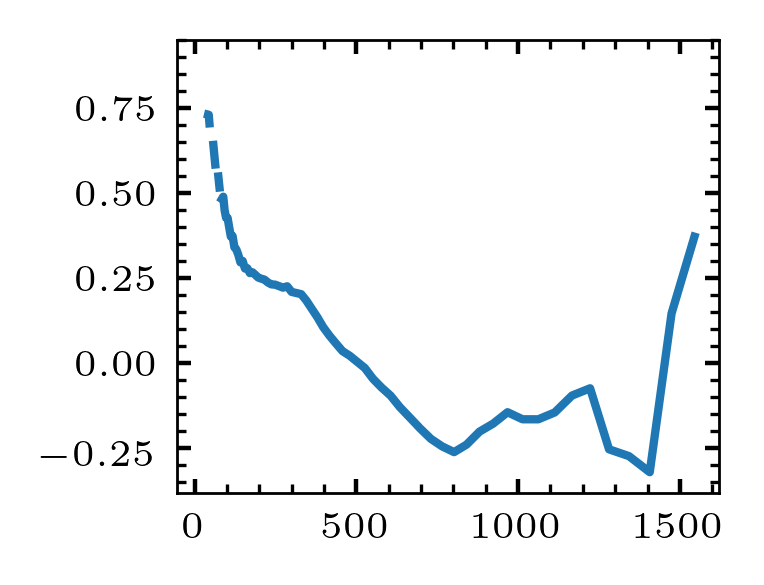

In [12]:
fig, ax = plt.subplots()
table = corrLib.distance_corr(X, Y, CI_old[:-1, :])
x, y = xy_bin(table.R, table.C)
ax.plot(x, y, label='old')
table = corrLib.distance_corr(XI, YI, CI_new)
x, y = xy_bin(table.R, table.C)
ax.plot(x, y, label='new')
ax.legend()

**Note:** the results are exactly the same.

In [26]:
def corrS_new(X, Y, U, V):
    row, col = X.shape
    vsqrt = (U ** 2 + V ** 2) ** 0.5
    U = U - U.mean()
    V = V - V.mean()
    Ax = U / vsqrt
    Ay = V / vsqrt
    CA = np.ones(X.shape)
    CV = np.ones(X.shape)
    for xin in range(0, col):
        for yin in range(0, row):
            if xin != 0 or yin != 0:
                CA[yin, xin] = (Ax[0:row-yin, 0:col-xin] * Ax[yin:row, xin:col] + Ay[0:row-yin, 0:col-xin] * Ay[yin:row, xin:col]).mean()
                CV[yin, xin] = (U[0:row-yin, 0:col-xin] * U[yin:row, xin:col] + V[0:row-yin, 0:col-xin] * V[yin:row, xin:col]).mean() / (U.std()**2+V.std()**2)
    return CA, CV

In [27]:
pivData = pd.read_csv('temp_data/piv-sample.csv')
row = len(pivData.y.drop_duplicates())
col = len(pivData.x.drop_duplicates())
mat = {}
for kw in pivData:
    mat[kw] = np.array(pivData[kw]).reshape(row, col)

In [37]:
r, c = mat['x'].shape

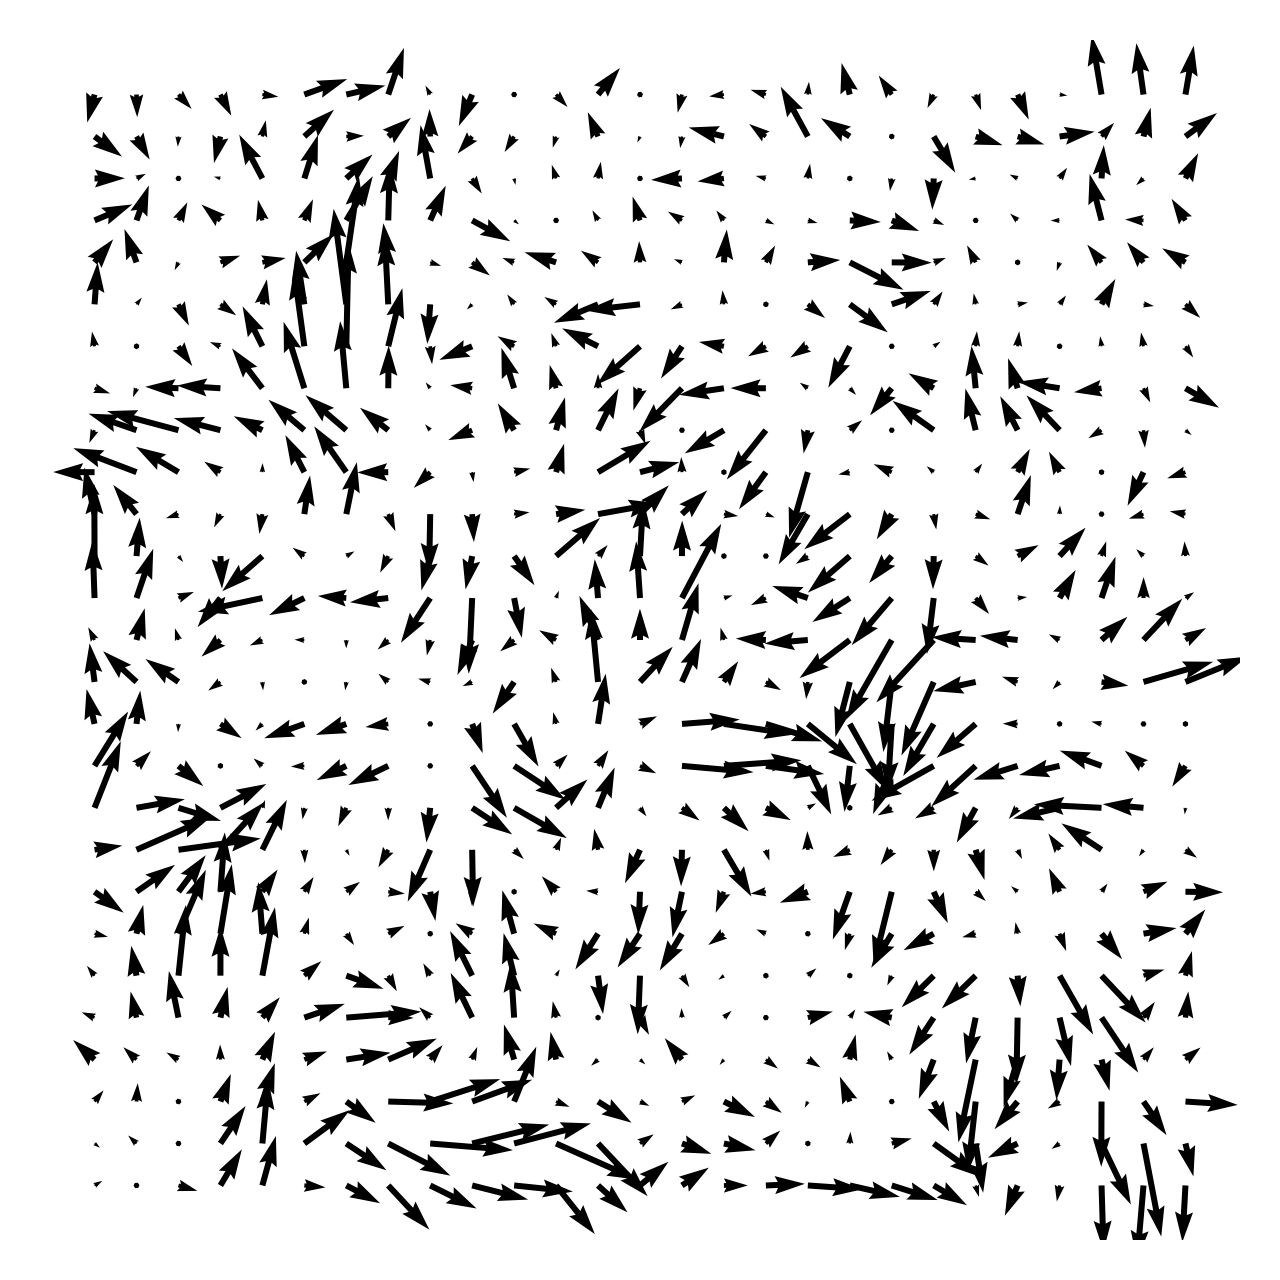

In [43]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0,0,1,1])
ax.quiver(mat['x'][0:r:3, 0:c:3], mat['y'][0:r:3, 0:c:3], mat['u'][0:r:3, 0:c:3], mat['v'][0:r:3, 0:c:3],
          color='black', width=0.005, scale=1000)
ax.axis('off')
fig.savefig(r'E:\Github\PhD-thesis\Figs\A-2\v-field.pdf')

In [28]:
tic = time.monotonic()
CA_old, CV_old = corrS(mat['x'], mat['y'], mat['u'], mat['v'])
toc = time.monotonic()
t_old = toc - tic
tic = time.monotonic()
CA_new, CV_new = corrS_new(mat['x'], mat['y'], mat['u'], mat['v'])
toc = time.monotonic()
t_new = toc - tic
print('old function: {:.2f} s'.format(t_old))
print('new function: {:.2f} s'.format(t_new))

old function: 52.06 s
new function: 0.84 s


E:\Github\Python\Correlation\src\corr_utils.py:1270: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1270: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


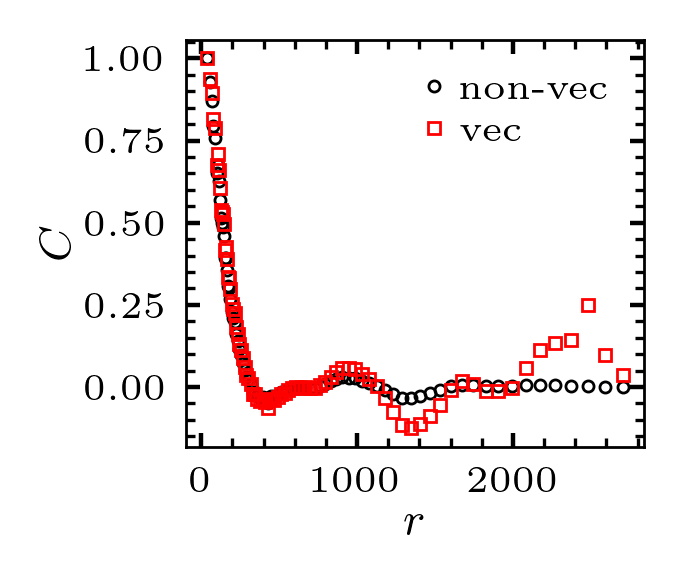

In [35]:
fig, ax = plt.subplots()
table = corrLib.distance_corr(mat['x'], mat['y'], CV_old)
x, y = xy_bin(table.R, table.C)
ax.plot(x, y, label='non-vec', marker='o', markersize=2, ls='', mfc=(0,0,0,0), mec='black', mew=0.5)
table = corrLib.distance_corr(mat['x'], mat['y'], CV_new)
x, y = xy_bin(table.R, table.C)
ax.plot(x, y, label='vec', marker='s', markersize=2, ls='', mfc=(0,0,0,0), mec='red', mew=0.5)
ax.legend()
ax.set_xlabel('$r$')
ax.set_ylabel('$C$')

plt.tight_layout()
fig.savefig(r'E:\Github\PhD-thesis\Figs\A-2\vectorization-comparison.pdf')

**Note:** no much difference

old method: 0.78 s
new method: 0.09 s
function is sped up 8.4 times


Text(0.5, 1.0, 'new method')

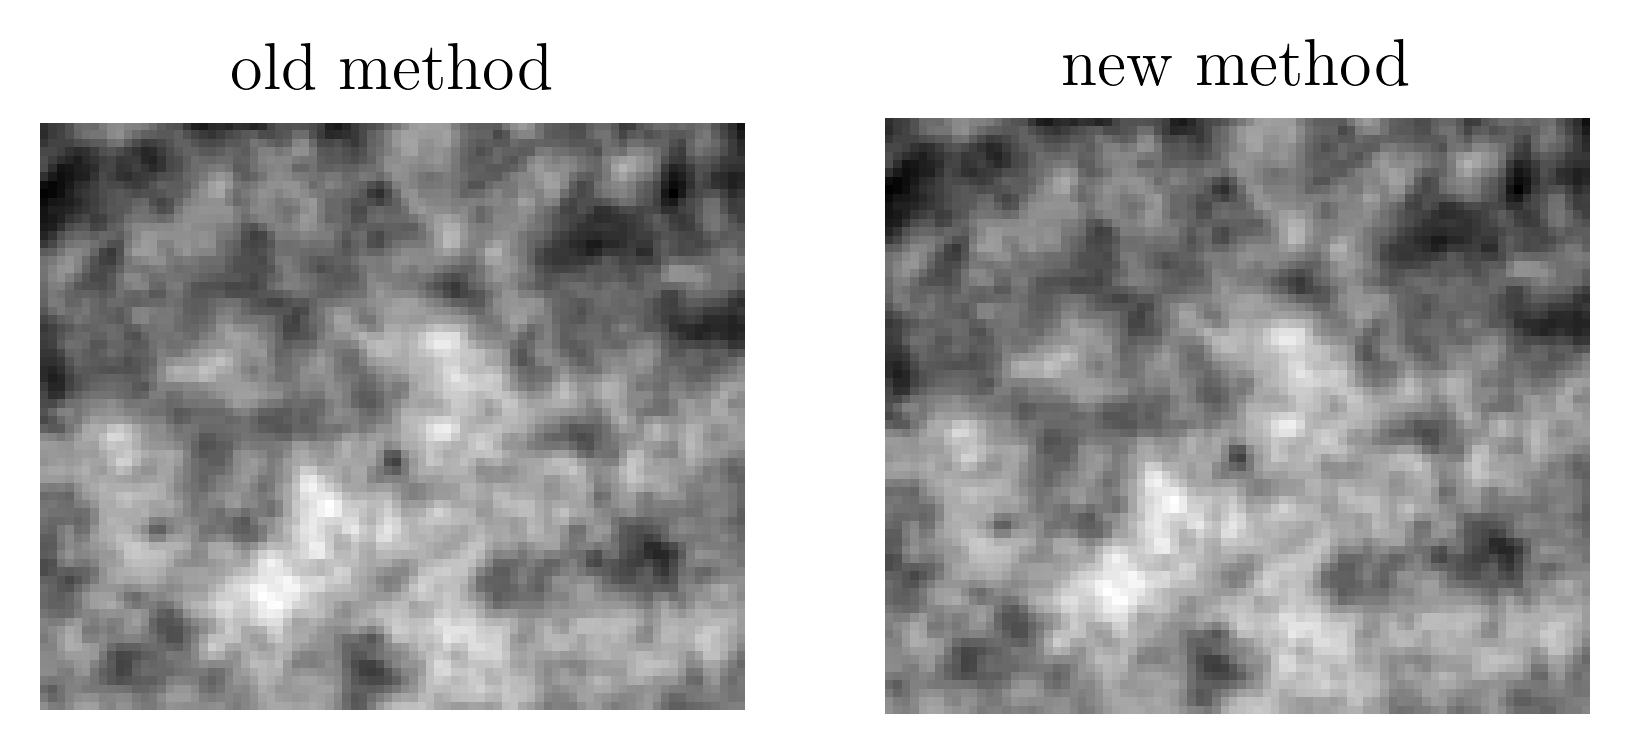

In [32]:
# coarse-grain the image, corrLib.divide_windows
tic = time.monotonic()
count = 0
while count < 10:
    count += 1
    X, Y, I_old = divide_windows(img, windowsize=[30, 30], step=15)
toc = time.monotonic()
t_old = toc - tic

# coarse-grain the image, skimage.util.view_as_windows + np.mean
tic = time.monotonic()
count = 0
while count < 10:
    count += 1
    I_new = util.view_as_windows(img, 30, step=15).mean(axis=(2, 3))
toc = time.monotonic()
t_new = toc - tic

print('old method: {:.2f} s'.format(t_old))
print('new method: {:.2f} s'.format(t_new))
print('function is sped up {:.1f} times'.format(t_old/t_new))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
ax[0].imshow(I_old, cmap='gray')
ax[0].axis('off')
ax[0].set_title('old method')

ax[1].imshow(I_new, cmap='gray')
ax[1].axis('off')
ax[1].set_title('new method')